In [ ]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Installing Necessary Libraries  ---
!pip install torch torchvision torchaudio --quiet

# --- Import Libraries ---
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.8 MB/s eta 0:00:00


In [ ]:
# --- Eye Image Transformations ---
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- Load Eye Dataset ---
eye_path = '/content/drive/My Drive/eye'

eye_dataset = torchvision.datasets.ImageFolder(eye_path, transform=transform)
eye_loader = DataLoader(eye_dataset, batch_size=32, shuffle=False)

# --- Check Class Mapping ---
print("Class Mapping:", eye_dataset.class_to_idx)


Class Mapping: {'drowsy': 0, 'ndrowsy': 1}


In [ ]:
# --- Load Pretrained Vision Transformer (ViT) ---
vit_model = torchvision.models.vit_b_16(weights='ViT_B_16_Weights.DEFAULT')
vit_model.heads = nn.Identity()  # Remove classification layer
vit_model.eval()

# --- Extract Eye Features Function ---
def extract_eye_features(loader):
    all_features = []
    all_labels = []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    vit = vit_model.to(device)
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            feats = vit(images)
            all_features.append(feats.cpu())
            all_labels.append(labels.cpu())
    features = torch.cat(all_features)
    labels = torch.cat(all_labels)
    return features.numpy(), labels.numpy()

# --- Run Feature Extraction ---
eye_features, eye_labels = extract_eye_features(eye_loader)

print("Eye Feature Shape:", eye_features.shape)
print("Eye Labels Shape:", eye_labels.shape)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 161MB/s]


Eye Feature Shape: (2005, 768)
Eye Labels Shape: (2005,)


In [ ]:
# --- Load EEG CSV ---
eeg_path = '/content/drive/My Drive/features_raw_eeg/features_raw.csv'
eeg_df = pd.read_csv(eeg_path)

# --- Handle NaN or constant columns ---
eeg_df = eeg_df.fillna(0)

# --- Standardize EEG Features ---
scaler_eeg = StandardScaler()
eeg_scaled = scaler_eeg.fit_transform(eeg_df)

# --- Match Rows with Eye Features ---
eeg_scaled = eeg_scaled[:2005]

print("EEG Feature Shape:", eeg_scaled.shape)


EEG Feature Shape: (2005, 33)


In [ ]:
# Load HRV
hrv_path = '/content/drive/My Drive/hrv/train.csv'
hrv_df = pd.read_csv(hrv_path)

# List of 32 good HRV feature columns (manually)
hrv_feature_cols = [
    'MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
    'pNN25', 'pNN50', 'SD1', 'SD2', 'KURT', 'SKEW', 'MEAN_REL_RR', 'MEDIAN_REL_RR',
    'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR', 'SDRR_RMSSD_REL_RR', 'KURT_REL_RR',
    'SKEW_REL_RR', 'VLF', 'VLF_PCT', 'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU',
    'TP', 'LF_HF', 'HF_LF'
]

# Only select these columns
hrv_df = hrv_df[hrv_feature_cols]

# Fill NaN if any
hrv_df = hrv_df.fillna(0)

# Standardize
from sklearn.preprocessing import StandardScaler
scaler_hrv = StandardScaler()
hrv_scaled = scaler_hrv.fit_transform(hrv_df)

# Match rows
hrv_scaled = hrv_scaled[:2005]

print("HRV Feature Shape:", hrv_scaled.shape)


HRV Feature Shape: (2005, 32)


In [ ]:
import numpy as np
import pandas as pd

# Step 1: Combine all features horizontally
full_features = np.hstack([eye_features, eeg_scaled, hrv_scaled])  # shape: (2005, 833)

# Step 2: Add labels as the last column
full_data = np.hstack([full_features, eye_labels.reshape(-1, 1)])  # shape: (2005, 834)

# Step 3: Create column names
eye_cols = [f"eye_{i}" for i in range(768)]
eeg_cols = [f"eeg_{i}" for i in range(33)]
hrv_cols = [f"hrv_{i}" for i in range(32)]
columns = eye_cols + eeg_cols + hrv_cols + ["label"]

# Step 4: Convert to DataFrame
df_merged = pd.DataFrame(full_data, columns=columns)

# Step 5: Save to CSV
df_merged.to_csv("/content/merged_multimodal_dataset.csv", index=False)
print(" Merged file saved as 'merged_multimodal_dataset.csv'")


 Merged file saved as 'merged_multimodal_dataset.csv'


In [ ]:
# --- Custom Dataset ---
class MultiModalDataset(Dataset):
    def __init__(self, eye_feats, eeg_feats, hrv_feats, labels):
        self.eye_feats = eye_feats
        self.eeg_feats = eeg_feats
        self.hrv_feats = hrv_feats
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'eye': torch.tensor(self.eye_feats[idx], dtype=torch.float),
            'eeg': torch.tensor(self.eeg_feats[idx], dtype=torch.float),
            'hrv': torch.tensor(self.hrv_feats[idx], dtype=torch.float),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
# --- Train/Test Split ---
from sklearn.model_selection import train_test_split

X_eye_train, X_eye_test, X_eeg_train, X_eeg_test, X_hrv_train, X_hrv_test, y_train, y_test = train_test_split(
    eye_features, eeg_scaled, hrv_scaled, eye_labels, test_size=0.2, random_state=42
)

# --- Create Train and Test Dataset ---
train_dataset = MultiModalDataset(X_eye_train, X_eeg_train, X_hrv_train, y_train)
test_dataset = MultiModalDataset(X_eye_test, X_eeg_test, X_hrv_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# --- Late Fusion Model with Meta-Classifier ---
class LateFusionModel(nn.Module):
    def __init__(self, eye_dim, eeg_dim, hrv_dim, hidden_size=128):
        super(LateFusionModel, self).__init__()

        self.eye_branch = nn.Sequential(
            nn.Linear(eye_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )

        self.eeg_branch = nn.Sequential(
            nn.Linear(eeg_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )

        self.hrv_branch = nn.Sequential(
            nn.Linear(hrv_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )

        self.fusion_head = nn.Sequential(
            nn.Linear(hidden_size * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, eye, eeg, hrv):
        eye_feat = self.eye_branch(eye)
        eeg_feat = self.eeg_branch(eeg)
        hrv_feat = self.hrv_branch(hrv)
        combined = torch.cat([eye_feat, eeg_feat, hrv_feat], dim=1)
        output = self.fusion_head(combined)
        return output


In [ ]:
# --- Instantiate Model ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LateFusionModel(eye_dim=eye_features.shape[1], eeg_dim=eeg_scaled.shape[1], hrv_dim=hrv_scaled.shape[1])
model = model.to(device)

model = model.to(device)

# --- Loss and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- Training Loop ---
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        eye = batch['eye'].to(device)
        eeg = batch['eeg'].to(device)
        hrv = batch['hrv'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(eye, eeg, hrv)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")
print("Training Complete!")

Epoch [1/10], Loss: 0.4259
Epoch [2/10], Loss: 0.2501
Epoch [3/10], Loss: 0.1621
Epoch [4/10], Loss: 0.1315
Epoch [5/10], Loss: 0.0958
Epoch [6/10], Loss: 0.0921
Epoch [7/10], Loss: 0.0945
Epoch [8/10], Loss: 0.0478
Epoch [9/10], Loss: 0.0372
Epoch [10/10], Loss: 0.0460
Training Complete!


In [ ]:
# --- Precision, Recall, F1 Score ---
from sklearn.metrics import precision_score, recall_score, f1_score

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        eye = batch['eye'].to(device)
        eeg = batch['eeg'].to(device)
        hrv = batch['hrv'].to(device)
        labels = batch['label'].to(device)

        outputs = model(eye, eeg, hrv)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9948
Recall: 0.9648
F1 Score: 0.9796


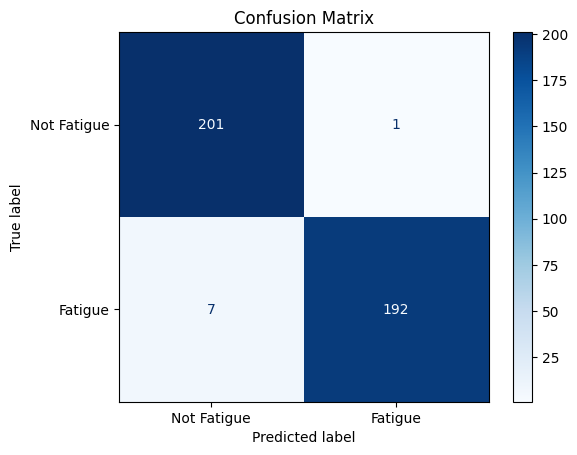

In [ ]:
# --- Confusion Matrix ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fatigue", "Fatigue"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# --- Test the Model ---
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        eye = batch['eye'].to(device)
        eeg = batch['eeg'].to(device)
        hrv = batch['hrv'].to(device)
        labels = batch['label'].to(device)

        outputs = model(eye, eeg, hrv)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct/total:.2f}%")


Test Accuracy: 98.00%


In [ ]:
import random

# --- Pick a random sample from test set
random_idx = random.randint(0, len(test_dataset) - 1)
sample = test_dataset[random_idx]

eye = sample['eye'].unsqueeze(0).to(device)  # add batch dimension
eeg = sample['eeg'].unsqueeze(0).to(device)
hrv = sample['hrv'].unsqueeze(0).to(device)
label_true = sample['label'].item()

# --- Make prediction
model.eval()
with torch.no_grad():
    output = model(eye, eeg, hrv)
    _, predicted = torch.max(output.data, 1)
    predicted = predicted.item()

# --- Map labels
label_map = {0: "Fatigue ", 1: "Not Fatigue "}

# --- Print result
print(f"True Label: {label_map[label_true]}")
print(f"Predicted Label: {label_map[predicted]}")


True Label: Fatigue 
Predicted Label: Fatigue 
